In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scikitplot.estimators import plot_feature_importances

## Load dataset

In [3]:
df = pd.read_csv("new_churn_data.csv")
df.sample(6)

,tenure,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_log,TotalCharges_Tenure_Ratio,MonthlyCharges_to_TotalCharges_Ratio,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Month-to-month,One year,Two year
6194,69,105.10,7234.80,0,4.654912,104.852174,0.014527,0,1,1,0,1,1,0
5153,23,54.15,1312.45,0,3.991758,57.063043,0.041259,0,0,0,0,0,0,0
5196,38,24.85,955.75,0,3.212858,25.151316,0.026001,0,0,0,0,0,0,0
4324,71,25.55,1898.10,0,3.240637,26.733803,0.013461,1,0,1,0,1,0,1
1147,1,18.85,18.85,0,2.936513,18.850000,1.000000,0,0,0,0,0,0,0
6588,7,70.75,450.80,1,4.259153,64.400000,0.156943,0,1,1,0,0,0,0


## Split data into features and targets

In [4]:
X = df.drop('Churn', axis=1)
y = df['Churn']

## Training and Test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit and display model metrics

In [6]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

print("Decision Tree:")
print("Training accuracy:", dt.score(X_train, y_train))
print("Testing accuracy:", dt.score(X_test, y_test))

Decision Tree:
Training accuracy: 0.9939555555555556
Testing accuracy: 0.7014925373134329


It is evident that there is presence of overfitting in the training data due to the large distinct values between the training and test accuracies

In [7]:
dt.get_depth()

38

A depth of 38 is absurd and suggests a very large discrepancy. Tuning the DT hyperparameters as below might be able to fix this.

## Tune hyperparameters for the DecisionTree

In [13]:
param_grid = {'max_depth': [2, 3, 5, 7, 10]} 
dt_model = DecisionTreeClassifier()
grid_search = GridSearchCV(dt_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 5, 7, 10]})

In [14]:
best_max_depth = grid_search.best_params_['max_depth']
best_max_depth

5

Here we found the best max depth to be 5

## Fit with the best hyperparameter

In [10]:
dt_model_tuned = DecisionTreeClassifier(max_depth=best_max_depth)
dt_model_tuned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [11]:
dt_model_tuned.get_depth()

5

In [12]:
print("Decision Tree:")
print("Training accuracy:", dt_model_tuned.score(X_train, y_train))
print("Testing accuracy:", dt_model_tuned.score(X_test, y_test))

Decision Tree:
Training accuracy: 0.8014222222222223
Testing accuracy: 0.7633262260127932


## Plot the decision tree

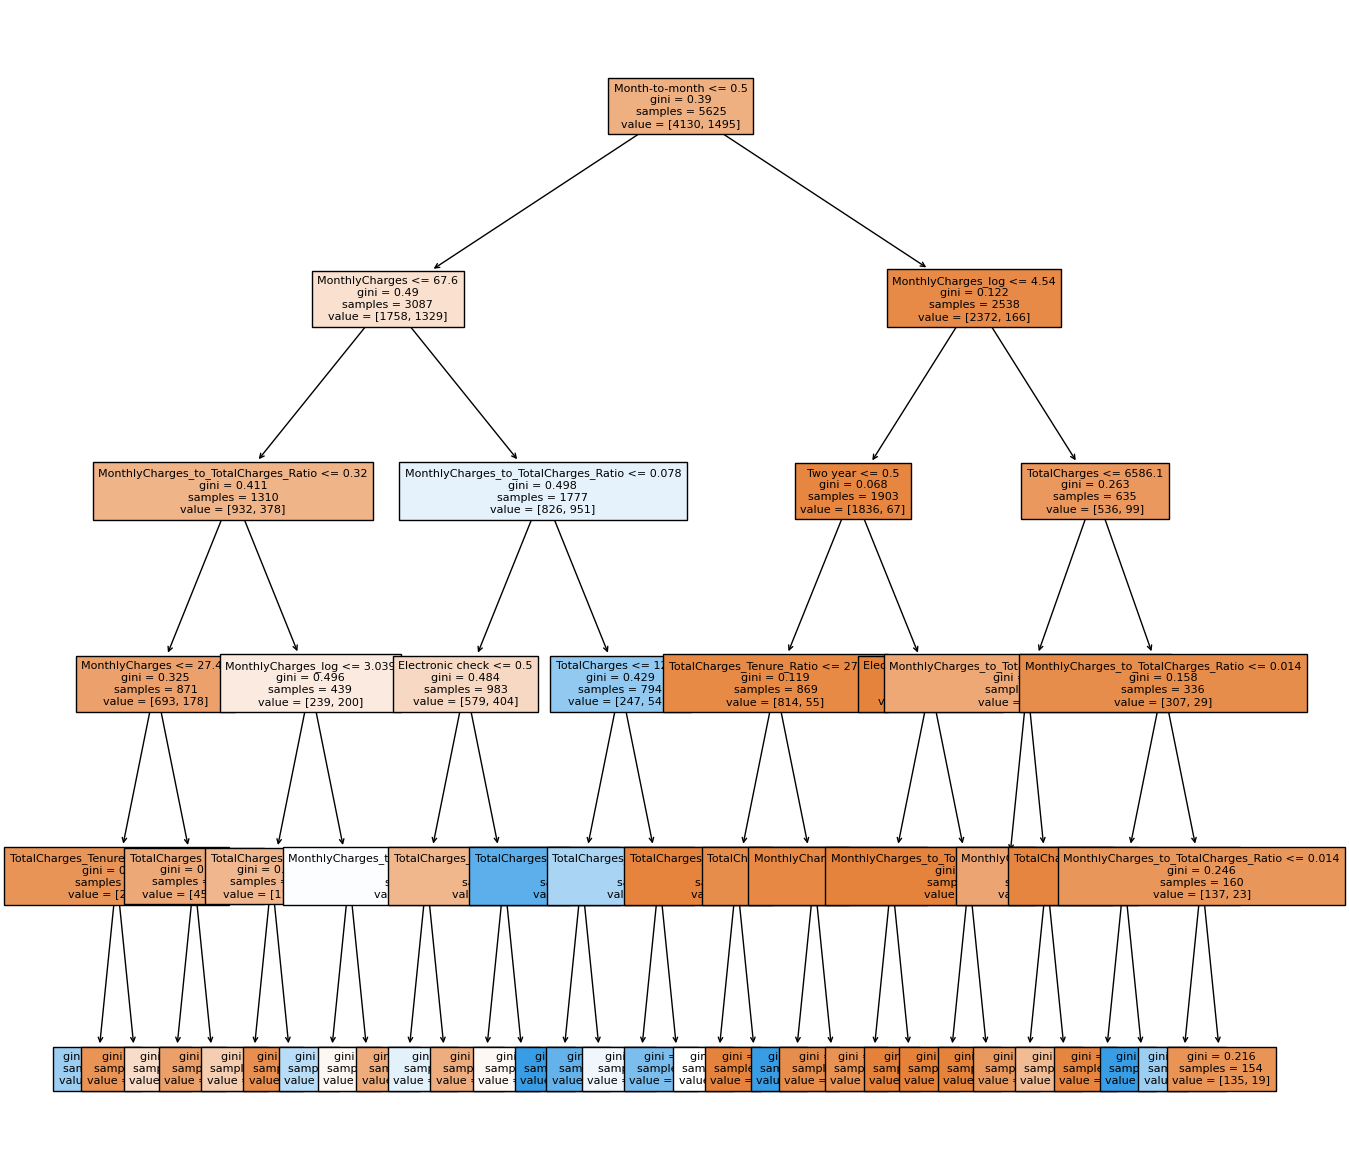

In [16]:
f = plt.figure(figsize = (15,15))
_ = plot_tree(dt_model_tuned,fontsize=8,feature_names = X.columns, filled=True)

## Plot correlations between features and targets

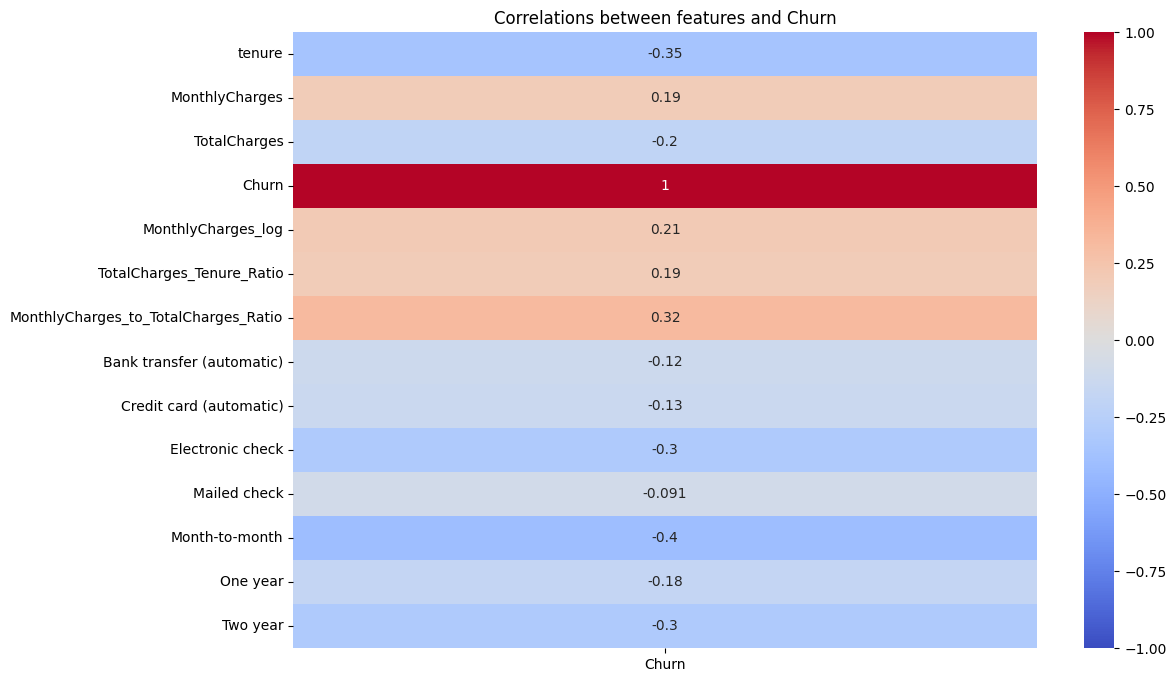

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr()[['Churn']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlations between features and Churn")
plt.show()

## Random Forest

In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))


0.9939555555555556
0.7668798862828714


The large deviation in accuracies prove that there is overfitting 

## Define hyperparameters for tuning

In [26]:
param_grid = {
    'max_depth': [2, 5, 10]
}

## Perform GridSearchCV for hyperparameter tuning

In [27]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 5, 10]})

## Get best parameters

In [28]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': 5}


## Evaluate RFC with best parameters

In [29]:
rf_best = RandomForestClassifier(random_state=42, **best_params)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [30]:
print("Random Forest:")
print("Training accuracy:", rf_best.score(X_train, y_train))
print("Testing accuracy:", rf_best.score(X_test, y_test))

Random Forest:
Training accuracy: 0.8060444444444445
Testing accuracy: 0.7867803837953091


These values have a relatively lesser difference therefore it can be noted that overfitting was dealt with

## Feature selection

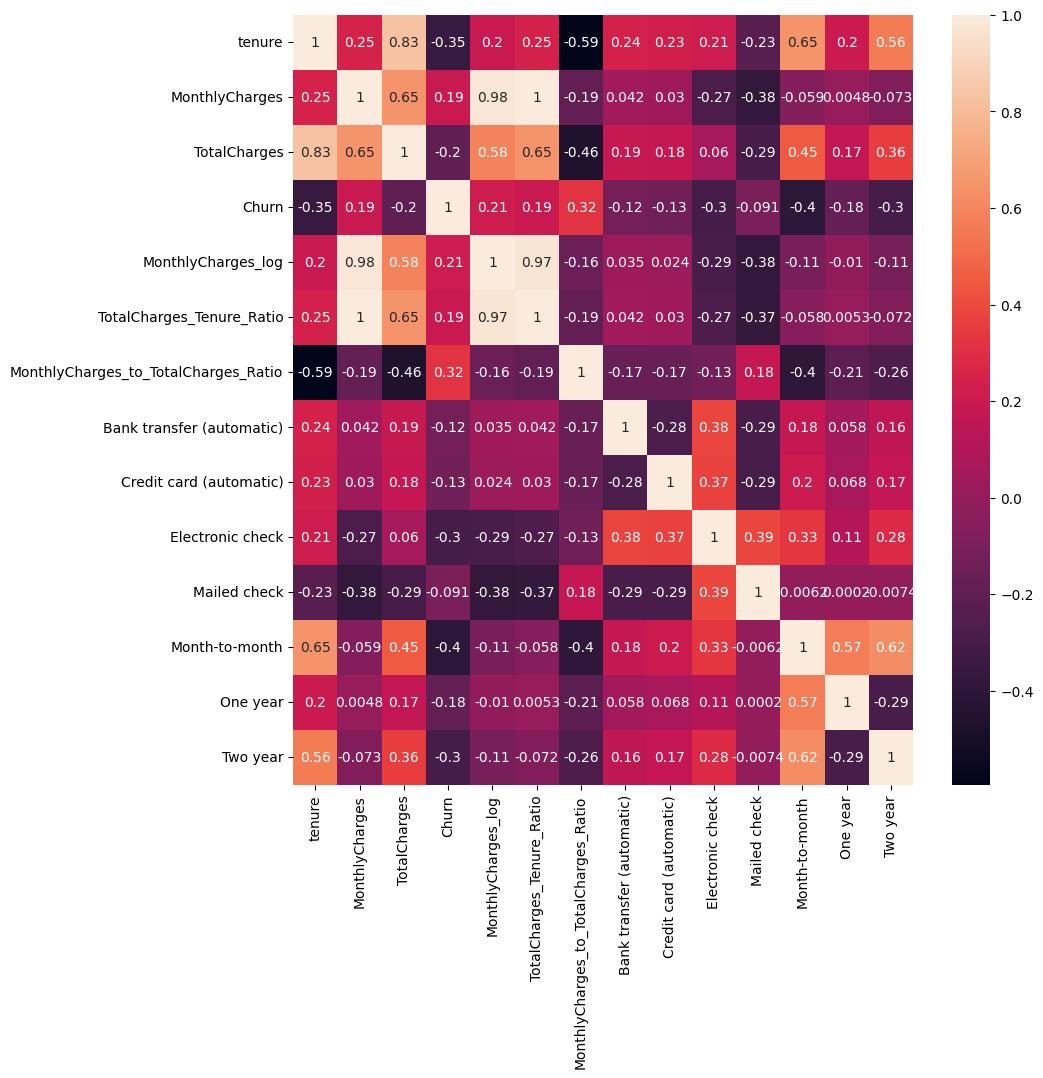

In [31]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()


## Plot feature importances

<Figure size 1000x600 with 0 Axes>

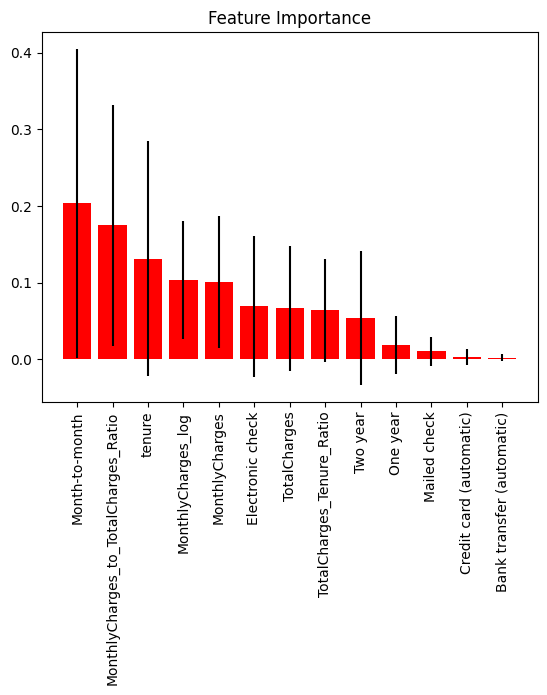

In [32]:
plt.figure(figsize=(10, 6))
plot_feature_importances(rf_best, feature_names=X.columns, x_tick_rotation=90)
plt.show()

Features from Electronic check to the left side of the plot seem to be less important

In [54]:
less_important_features =['Electronic check', 'TotalCharges', 'TotalCharges_Tenure_Ratio','Two year','One year','Mailed check','Credit card (automatic)', 'Bank transfer (automatic)']



X_train_filtered = X_train.drop(less_important_features, axis=1)
X_test_filtered = X_test.drop(less_important_features, axis=1)



In [55]:
# Verify the shapes of X_train and y_train
print("Shape of X_train:", X_train_filtered.shape)
print("Shape of y_train:", y_train.shape)

# Fit the RandomForestClassifier
rf_model_filtered = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_filtered.fit(X_train_filtered, y_train)

Shape of X_train: (5625, 5)
Shape of y_train: (5625,)


RandomForestClassifier(random_state=42)

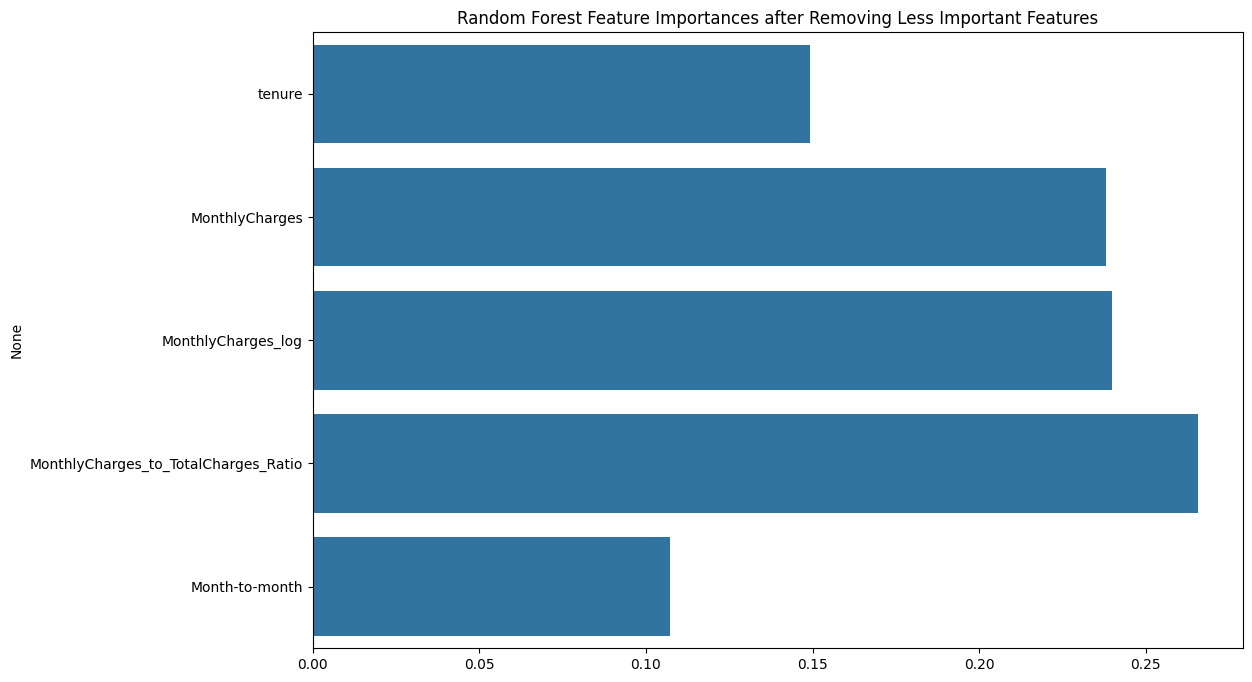

In [56]:
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_model_filtered.feature_importances_, y=X_train_filtered.columns)
plt.title("Random Forest Feature Importances after Removing Less Important Features")
plt.show()

## Evaluate Model performance

In [58]:
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

## RF with no less important features

In [60]:
print("\nEvaluation of Random Forest Model after Removing Less Important Features:")
evaluate_model(rf_model_filtered, X_test_filtered, y_test)


Evaluation of Random Forest Model after Removing Less Important Features:
Accuracy: 0.7548, Precision: 0.5469, Recall: 0.4519, F1 Score: 0.4949


## Summary

We conduct a comprehensive analysis of churn data using Decision Trees and Random Forest. Initially, the data is loaded and divided into features and the target variable.
 
Following this, the dataset is split into training and testing sets. The analysis begins with Decision Trees, where an initial model is trained and evaluated for accuracy on both the training and testing sets. Subsequently, hyperparameter tuning is performed using GridSearchCV to optimize the max_depth parameter, enhancing the model's performance. Similar steps are followed for Random Forests, where an initial model is trained and evaluated, followed by hyperparameter tuning to optimize the max_depth. Feature selection techniques are then employed, visualizing feature correlations and identifying important features using plot_feature_importances. 

Less important features are removed, and a new Random Forest model is trained on the filtered dataset. Finally, the performance of the filtered model is evaluated using metrics such as accuracy, precision, recall, and F1-score, aiming to build an accurate predictive model for identifying potential churners in the dataset.